In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
from tqdm import tqdm

In [2]:
from torch.utils.data import DataLoader
from preprocess import PairedDataset, load_images, visualize_from_dataloader
from torchmetrics.image import StructuralSimilarityIndexMeasure, PeakSignalNoiseRatio
from models import ESAU

In [3]:
hd_train = load_images("/home/ub/Documents/Ritik/Mayo2016_2d/train/full_1mm")
hd_val = load_images("/home/ub/Documents/Ritik/Mayo2016_2d/val/full_1mm")
hd_test = load_images("/home/ub/Documents/Ritik/Mayo2016_2d/test/full_1mm")

ld_train = load_images("/home/ub/Documents/Ritik/Mayo2016_2d/train/quarter_1mm")
ld_val = load_images("/home/ub/Documents/Ritik/Mayo2016_2d/val/quarter_1mm")
ld_test = load_images("/home/ub/Documents/Ritik/Mayo2016_2d/test/quarter_1mm")

## Custom Dataset for Paired Images

In [4]:
# Create paired datasets!
train_data = PairedDataset(ld_train, hd_train)
val_data = PairedDataset(ld_val, hd_val)
test_data = PairedDataset(ld_test, hd_test)

# Create dataloaders: more-batch size given to training dataloader!
train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
val_loader = DataLoader(val_data, batch_size=2, shuffle=False)
test_loader = DataLoader(test_data, batch_size=2, shuffle=False)

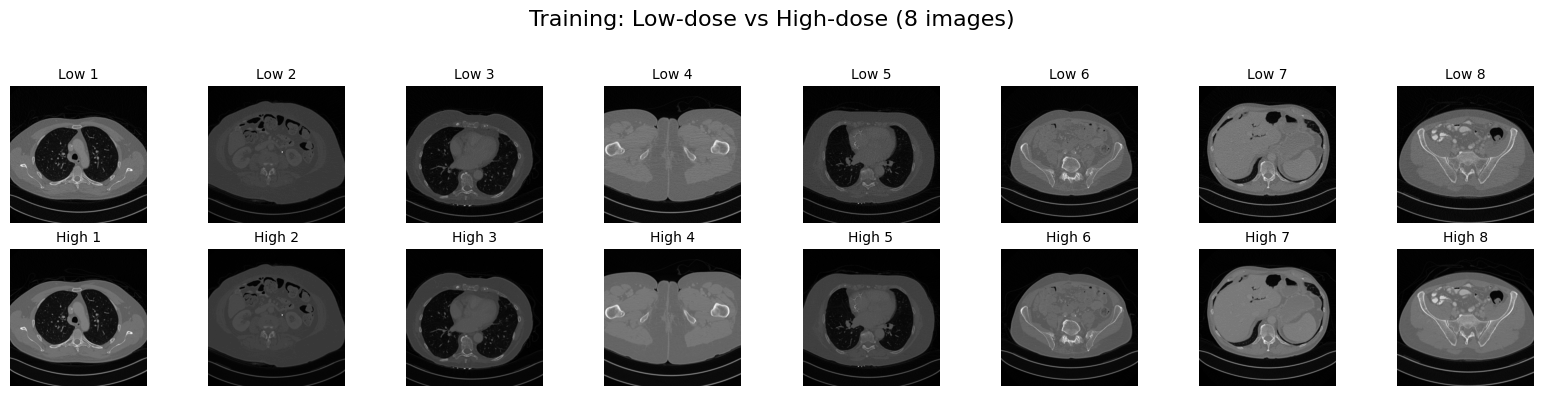

In [5]:
visualize_from_dataloader(train_loader, dataset_name="Training")

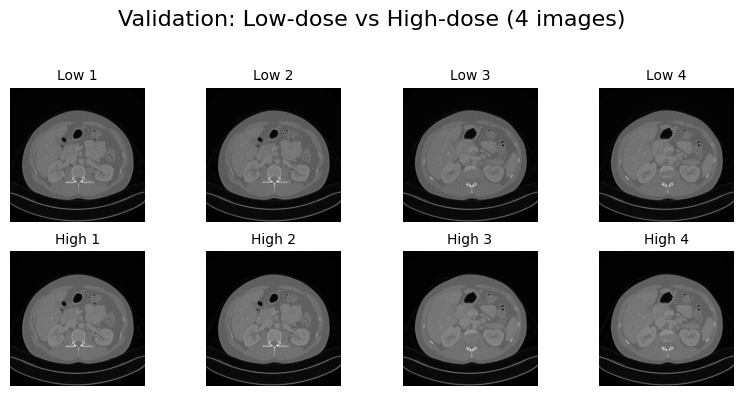

In [6]:
visualize_from_dataloader(val_loader, dataset_name="Validation")

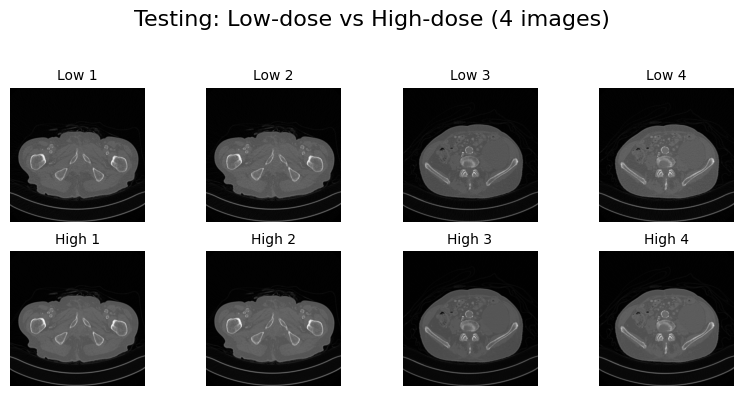

In [7]:
visualize_from_dataloader(test_loader, dataset_name="Testing")

## Training Setup

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ESAU().to(device)
parameters = sum(p.numel() for p in net.parameters() if p.requires_grad)  # Count only trainable parameters
print(f"Generator parameters: {parameters}")

Generator parameters: 1221102


In [9]:
# Initialize torchmetrics for GPU-based SSIM and PSNR calculations
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
psnr_metric = PeakSignalNoiseRatio(data_range=1.0).to(device)

# 3) Set up loss, optimizer, and learning rate scheduler.
criterion = nn.L1Loss()  # Using L1 loss (Mean Absolute Error)

optimizer = optim.Adam(net.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-6)

# Directory to save model checkpoints
checkpoint_dir = "eunet_models"
os.makedirs(checkpoint_dir, exist_ok=True)

# Lists to store loss history
train_loss_history = []
val_loss_history = []
train_ssim_history = []
val_ssim_history = []
train_psnr_history = []
val_psnr_history = []

## Training Loop


In [10]:
# 4) Training loop with torchmetrics and combined loss
EPOCHS = 100
SCALE = 0.25

# Create progress bar for epochs
epoch_pbar = tqdm(range(1, EPOCHS + 1), desc="Progress")

for epoch in epoch_pbar:
    net.train()
    running_train_loss = 0.0
    train_ssim = 0.0
    train_psnr = 0.0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        
        # Calculate L1 loss and SSIM loss
        l1_loss = criterion(outputs, targets)
        ssim_loss = 1 - ssim_metric(outputs, targets)  # SSIM loss is 1 - SSIM
        
        # Combined loss: L1 + 0.1 * SSIM loss
        loss = l1_loss + SCALE * ssim_loss

        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * inputs.size(0)

        # Calculate metrics on GPU using torchmetrics
        with torch.no_grad():
            train_ssim += ssim_metric(outputs, targets).item() * inputs.size(0)
            train_psnr += psnr_metric(outputs, targets).item() * inputs.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    avg_train_ssim = train_ssim / len(train_loader.dataset)
    avg_train_psnr = train_psnr / len(train_loader.dataset)

    train_loss_history.append(epoch_train_loss)
    train_ssim_history.append(avg_train_ssim)
    train_psnr_history.append(avg_train_psnr)

    # Validation
    net.eval()
    running_val_loss = 0.0
    val_ssim = 0.0
    val_psnr = 0.0
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            
            # Calculate validation loss with same combined formula
            l1_loss = criterion(outputs, targets)
            ssim_loss = 1 - ssim_metric(outputs, targets)
            loss = l1_loss + 0.1 * ssim_loss
            
            running_val_loss += loss.item() * inputs.size(0)

            # Calculate metrics on GPU using torchmetrics
            val_ssim += ssim_metric(outputs, targets).item() * inputs.size(0)
            val_psnr += psnr_metric(outputs, targets).item() * inputs.size(0)

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    avg_val_ssim = val_ssim / len(val_loader.dataset)
    avg_val_psnr = val_psnr / len(val_loader.dataset)

    val_loss_history.append(epoch_val_loss)
    val_ssim_history.append(avg_val_ssim)
    val_psnr_history.append(avg_val_psnr)

    # Learning Rate Check!
    scheduler.step()

    # Save model checkpoint
    checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch:03d}.pth")
    torch.save(net.state_dict(), checkpoint_path)

    # Update tqdm progress bar with current metrics
    epoch_pbar.set_postfix({
        'Train Loss': f'{epoch_train_loss:.3f}',
        'Val Loss': f'{epoch_val_loss:.3f}',
        'Train SSIM': f'{avg_train_ssim:.3f}',
        'Val SSIM': f'{avg_val_ssim:.3f}',
        'Train PSNR': f'{avg_train_psnr:.3f}',
        'Val PSNR': f'{avg_val_psnr:.3f}'
    })

    # Clear GPU cache to prevent memory issues
    torch.cuda.empty_cache()


Progress: 100%|██████████| 100/100 [15:40:34<00:00, 564.35s/it, Train Loss=0.018, Val Loss=0.011, Train SSIM=0.955, Val SSIM=0.960, Train PSNR=40.665, Val PSNR=40.885] 


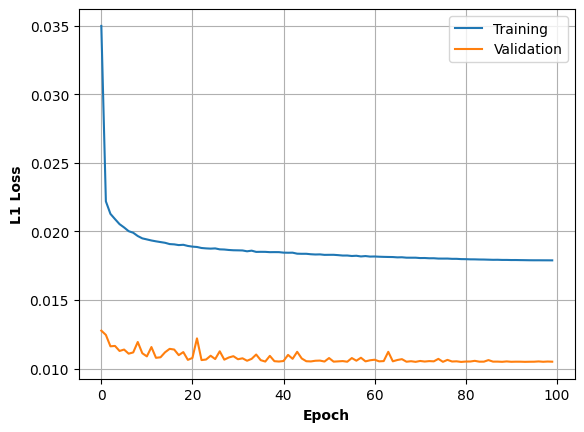

In [11]:
plt.plot(train_loss_history, label='Training')
plt.plot(val_loss_history, label='Validation')
plt.xlabel('Epoch', weight='bold')
plt.ylabel('L1 Loss', weight='bold')
plt.legend()
plt.grid(True)
plt.savefig('eunet_logs/loss.png')
plt.show()

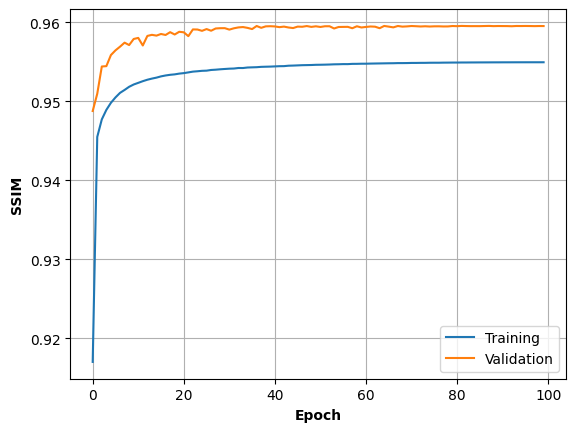

In [12]:
plt.plot(train_ssim_history, label='Training')
plt.plot(val_ssim_history, label='Validation')
plt.xlabel('Epoch', weight='bold')
plt.ylabel('SSIM', weight='bold')
plt.legend()
plt.grid(True)
plt.savefig('eunet_logs/ssim.png')
plt.show()

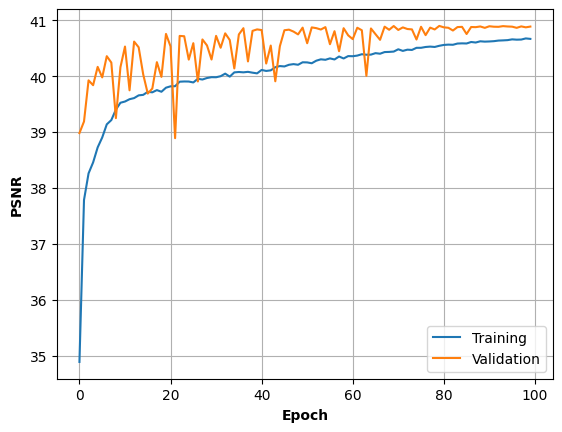

In [13]:
plt.plot(train_psnr_history, label='Training')
plt.plot(val_psnr_history, label='Validation')
plt.xlabel('Epoch', weight='bold')
plt.ylabel('PSNR', weight='bold')
plt.legend()
plt.grid(True)
plt.savefig('eunet_logs/psnr.png')
plt.show()

In [14]:
from evaluate import load_model, evaluate_on_test_set, visualize_predictions

In [15]:
# Initialize your model (ensure it matches the architecture used for training)
# checkpoint_path = "eunet_models/model_epoch_042.pth" 
# net = EUNet().to(device)
# net = load_model(checkpoint_path, net)

In [16]:
evaluate_on_test_set(net, test_loader)

Test Loss: 0.0126 | Test SSIM: 0.9708 | Test PSNR: 43.0465


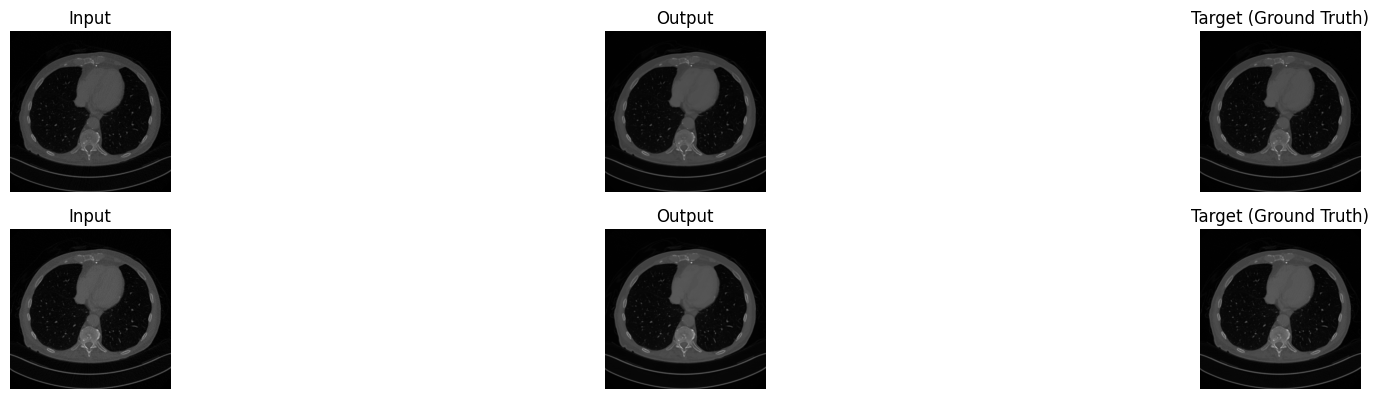

In [17]:
visualize_predictions(net, test_loader, num_samples=6)